これは[Learning-Agencyコンペ](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview)のノートブックであるAES2.0:KerasNLPを勉強したときのノートブックである

- [original notebook Link](https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter#%F0%9F%8D%BD%EF%B8%8F-%7C-Preprocessing)

- [original notebook Link](https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter#%F0%9F%8D%BD%EF%B8%8F-%7C-Preprocessing)

## 使用するモデル
KerasNLPを使用した順序回帰(Ordinal Regression),クラス分類(Classificatioin)を使用する。KerasNLPはTensorflowでもPyTorchでもいける

<dl>
<dt> 順序回帰</dt>
<dd>目的変数が順序尺度をもつとき、それを予測する回帰分析。
    "当てはまる","どちらかといえば当てはまる","当てはまらない"など。これは[Learning-Agencyコンペ](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview)のノートブックであるAES2.0:KerasNLPを勉強したときのノートブックである

- [original notebook Link](https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter#%F0%9F%8D%BD%EF%B8%8F-%7C-Preprocessing)
    線形回帰は連続値の予測、ロジスティック回帰では２値分類の予測、順序回帰は複数のカテゴリの予測をすることになる　
</dd>
</dl>


In [1]:
#ライブラリのipomrt
import os
os.environ["Keras"] = "jax"
#! pip install keras keras-nlp インストールした
import keras_nlp
import keras
K = keras.backend
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
#matlibのカラーマップを取得(coolwarmというカラーマップ)
#ここcmap = mpl.cm.get_cmap('coolwarm')これいじゃうまくいかない(よくわからん)
#cmap = plt.cm.coolwarm
cmap = mpl.cm.get_cmap('coolwarm')


2024-06-07 00:57:40.596772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 00:57:40.596886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 00:57:40.727906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_26/1831133155.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [2]:
#構成情報
class CFG:
    seed = 42 #random seed
    preset = "deberta_v3_extra_small_en" #train modelの名前
    sequence_length = 512 #入力テキストの最大長
    epochs = 5
    batch_size = 32
    scheduler = "cosine"  #学習率をcosine関数で変化させる

### Random Seed
乱数生成器による乱数を固定するためのシード値のこと。これは機械学習によるモデル比較の際、乱数による影響を受けないように固定することで再現性が保たれる。

ちなみに４２はよく見るけどこれはよくわからんSF小説の名シーン発祥のミームみたいな感じらしい(42はbinaryで101010が都合いいとか理由はあるけど、たぶんなんでもいい数値)。

In [3]:
#Reproducibility 再現性の確保
keras.utils.set_random_seed(CFG.seed)
#Mixed Precision
keras.mixed_precision.set_global_policy("mixed_float16")

### Mized Precision
混合制度とは数値表現をいくつか使用し、精度と効率を上げる手法。今回はfloat16として、学習の効率を上げる目的でコーディングされている。

In [4]:
#Load
#Dataset Path
BASE_PATH = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2'
df = pd.read_csv(BASE_PATH + "/train.csv")

print("# Train Data: {:,}".format(len(df)))
display(df.head(2))

# Train Data: 17,307


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3


In [5]:
#データ処理
from sklearn.model_selection import train_test_split

#データ分割:各クラス割合が元のdfと同じになるよう層化抽出法を使用
#4:1に分割するパラメータが0.2,stratifyは層化抽出法をscore列に対して行っている
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["score"]) 



### 層化抽出(stratified k-fold)
分類の際にクラス割合を等しくすること。極度に頻度が少ないクラスに対してぶれが生じるのを防いでいる。層内分散は小さく、層間分散は大きくすることでモデルの精度を高める手法。
- [リンク1](https://service.nikkei-r.co.jp/glossary/stratified-sampling)

### 順序回帰のラベル変換
順序回帰ではラベル変換も通常と異なる。以下がそのラベル変換の例であり、整数で表されたクラスベクトルを順序行列に変換している。


In [6]:
#convert to ordinal matrix

#難しいコードの書き方だけど具体例見れば処理の様子は簡単
def to_ordinal(y, num_classes=None, dtype="float32"):
    y = np.array(y, dtype="int") #yを整数型numpy配列に変換
    input_shape = y.shape
    
    if input_shape and input_shape[-1] == 1 and len(input_shape) >1:
        input_shape = tuple(input_shape[:-1])

        
    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y)+1
    
    #クラス数-1の長さの行列を作成し、クラス値よりも小さい部分に1を割り当てる
    n = y.shape[0]
    range_values = np.arange(num_classes -1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    #print(range_values)
    ordinal = np.zeros((n, num_classes-1), dtype=dtype)
    #print(range_values)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    
    output_shape = input_shape + (num_classes-1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

"""to_ordinalの説明
最終的な出力は与えられたサンプル配列をサンプルkを1の数でk行目に表されている
num_classes:クラスの総数
input_shape:y.shapeで得られるのは(配列の次元数,各次元のサイズ)、つまり(行、列)
初めのifでは"(...,1)の形状である"が条件
np.expand_dims():配列次元数を増やす関数  expand_dims([1,2,3], axis=1)=[[1],[2],[3]]
np.tile(array,reps):arrayをreps回繰り返すタプル
"""
#exam
scores = [1,3,9,2,6]
to_ordinal(scores)
        

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0.]], dtype=float32)

In [7]:
#label convert
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()
#print(train_df)

# EDA

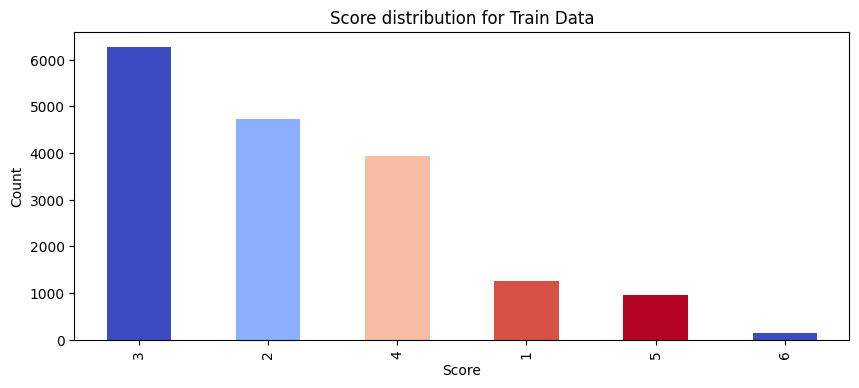

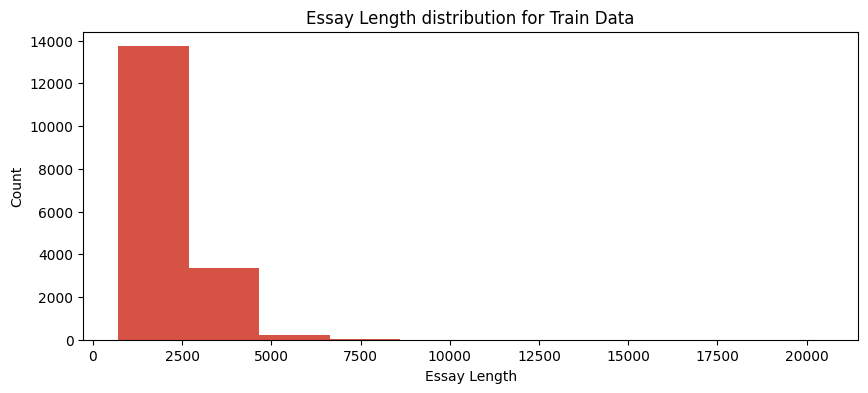

In [8]:
plt.figure(figsize=(10, 4))
df.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

plt.figure(figsize=(10, 4))
df['essay_length'] = df.full_text.map(len)
df.essay_length.plot.hist(logy=False, color=cmap(0.9))
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()



# preprocess
前処理されたテンソルを含む辞書 (token_ids、padding_mask) に変換

- tokenization:分割処理。トークンは通常、文章を構成する要素であり、単語や句読点、数字、記号などが含まれます。トークン化は、テキストをより小さな単位に分割することで、機械学習モデルや解析のためにテキストデータを準備する際に重要な前処理ステップ

[トークン化:Keras公式ドキュメント](https://keras.io/api/keras_nlp/preprocessing_layers/)

- padding:テキストサイズを一定にするために特別な文字を利用して埋め合わせる。
「The quick brown fox」を ["the", "qu", "##ick", "br", "##own", "fox"] に変換するなど

[パディング:Keras公式ドキュメント](https://keras.io/api/keras_nlp/tokenizers/)

In [9]:
#preprosessor:今回はDebertaV3Preprocessor
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, 
    sequence_length=CFG.sequence_length, 
)

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


In [10]:
#出力は(num_choice, sequence_length)
inp = preprocessor(df.full_text.iloc[0])  # dfのfulltext列の0行目だけpreprocessする

# Display
for k, v in inp.items():
    print(k, ":", v.shape)
    
    
#わかりやすいテスト
# テスト用の入力データ
#test_input = "This is a test input."

# 前処理の実行
#processed_input = preprocessor(test_input)

#print(processed_input)

token_ids : (512,)
padding_mask : (512,)


In [11]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  
    return (text, label) if label is not None else text 

# DataLoader
tensorflowのts.data.Datasetオブジェクトを使用
[細かい話:公式ドキュメント](https://www.tensorflow.org/guide/data?hl=ja)


In [12]:
def build_dataset(texts, labels=None, batch_size=32, 
                  cache=True, drop_remainder=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE
    slices = (texts,) if labels is None else (texts, labels) #labelが存在するならテキストと一緒にsiliceに格納
    ds = tf.data.Dataset.from_tensor_slices(slices) #テンソルスライスからデータセットを構築
    ds = ds.cache() if cache else ds #キャッシュがtrueならデータをキャッシュ
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)
    opt = tf.data.Options() 
    
    if shuffle:
        ds = ds.shuffle(shuffle, seed = CFG.seed) #シャッフルする
        opt.experimental_deterministic = False #シャッフルの非決定性を指定
        
    ds = ds.with_options(opt) #オプション指定
    ds = ds.batch(batch_size, drop_remainder=drop_remainder) #バッチ処理指定
    ds = ds.prefetch(AUTO) #データセットを自動チューニングでプリフェッチ
    return ds

In [13]:
#Build train/Valid Dataset

train_texts = train_df.full_text.tolist()
train_labels = np.array(train_df.label.tolist())
#build train
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True)

#valid data
validtexts = valid_df.full_text.tolist()
valid_labels = np.array(valid_df.label.tolist())
#build valid
valid_ds = build_dataset(
    validtexts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)


# LR Schedule(Learning Rate Shedule)
学習率スケジューラの実装。model trainingにおいてスケジューリングは重要。lr_startからlr_minまで学習率を低下させていく。スケジュールの方法は以下
- step:階段状のように段階的に学習率を下げる
- cos:コサインカーブで下げる
- exp:指数関数的に下げる

**LR Scheduleサイト**
- [サイト1](https://qiita.com/kma-jp/items/81db6d5c549e50707e30)
- [サイト2](https://wonderfuru.com/scheduler/)
- [サイト3(torch使い方)](https://zenn.dev/yuto_mo/articles/6e2803495029d4)
- [サイト4(torch)](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook)


In [14]:
import math

#スケジューラ関数
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False): #modeはstep,cos,expのどれか
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    #ランプアップエポック数、持続エポック数、学習率減衰率(今回は2エポックは学習率増やしてそこから持続させずに減衰フェーズに入る))
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75 

    def lrfn(epoch):  # epoch受け取って学習率の計算
        #ランアップフェーズ
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        #持続フェーズ
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        #減衰フェーズ
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  #lr curveをplot
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

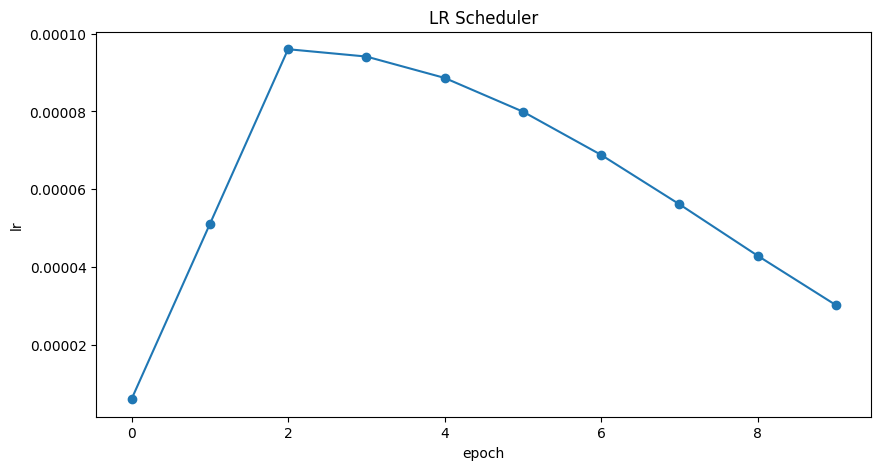

In [15]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)
#mode指定すると結構スケジューリング違くなる

# Model Checkponting
submitでの推論に使用する最適チャックポイントの保存

In [16]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5", #保存される重みのファイルパス
    monitor="val_weighted_kappa",#監視指標
    save_best_only=True,#指標が改善されたときのみ保存
    save_weights_only=True,#重みのみ保存かモデル全体を保存か
    mode="max",#監視指標がmaxのときに保存
)


# Metric
今回のMetric(モデル性能評価)はWeighted Kappa(加重Kappa)

以下のコードはすこし今回のコンペとは違うらしい
- [改良コードnotebook](https://www.kaggle.com/code/taichiuemura/aes-2-0-kerasnlp-starter/notebook#%F0%9F%93%8F-%7C-Metric)

In [17]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")

        self.o_sum = self.add_weight(name = 'o_sum', initializer = 'zeros')
        self.e_sum = self.add_weight(name = 'e_sum', initializer = 'zeros')
        
    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(keras.ops.sum(keras.ops.cast(y_true, dtype="int32"), axis=-1) - 1, 6)
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(keras.ops.cast(y_pred > 0.5, dtype="int8"), dtype="int32"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(keras.ops.sum(
            keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
        ))
        


    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )
        

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)

        
        self.o_sum.assign(0)
        self.e_sum.assign(0)
        

In [18]:
from sklearn.metrics import cohen_kappa_score

metric = WeightedKappa()
y_true = np.array([
    [1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1],
])
y_pred = np.array([
    [1., 0.8, 0.3, 0.2, 0., 0.],
    [0.9, 0.86, 0.7, 0.4, 0.3, 0.1],
    [0.9, 0.9, 0.8, 0.6, 0.2, 0.],
    [1., 1., 0.8, 0.7, 0.6, 0.3],
])
metric.update_state(y_true, y_pred)
print('Custom metric:', metric.result())
print('sklearn metric:', cohen_kappa_score(
    np.sum(y_true > 0.5, axis = 1),
    np.sum(y_pred > 0.5, axis = 1),
    weights = 'quadratic',
))

Custom metric: tf.Tensor(0.45, shape=(), dtype=float32)
sklearn metric: 0.44999999999999996


# Modeling
KerasNLPライブラリを使用(Bert,Roberta,DebertaV3など既存のトレーニング済みモデルある)
- [KerasNLP models](https://keras.io/api/keras_nlp/models/)
- [KerasNLP Getting Started](https://keras.io/guides/keras_nlp/getting_started/)

今回はkeras_nlp.models.DebertaV3Classifierを使用してロジットを生成し、シグモイド関数に渡すことで最終出力を作成する。また、num_class=6,softmax関数、categorical_crossentrpy損失関数,を使用することもある。


In [19]:
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)
model.summary()


Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 6)         │ 70,832,262 │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,832,262 (270.20 MB)

 Trainable params: 70,832,262 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

# training

In [20]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/5


I0000 00:00:1717722065.609939      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717722065.817056      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


432/432 ━━━━━━━━━━━━━━━━━━━━ 523s 802ms/step - loss: 0.4617 - weighted_kappa: 0.1430 - val_loss: 0.2105 - val_weighted_kappa: 0.6430 - learning_rate: 6.0000e-06
Epoch 2/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 340s 788ms/step - loss: 0.1977 - weighted_kappa: 0.6661 - val_loss: 0.1688 - val_weighted_kappa: 0.7394 - learning_rate: 5.1000e-05
Epoch 3/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 380s 783ms/step - loss: 0.1632 - weighted_kappa: 0.7454 - val_loss: 0.1716 - val_weighted_kappa: 0.7431 - learning_rate: 9.6000e-05
Epoch 4/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 336s 777ms/step - loss: 0.1425 - weighted_kappa: 0.7901 - val_loss: 0.1551 - val_weighted_kappa: 0.7706 - learning_rate: 9.4116e-05
Epoch 5/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 331s 765ms/step - loss: 0.1218 - weighted_kappa: 0.8356 - val_loss: 0.1818 - val_weighted_kappa: 0.7446 - learning_rate: 8.8618e-05


## Result Summary

In [21]:
# 最もよかったエポック
best_epoch = np.argmax(model.history.history['val_weighted_kappa']) #argmaxで最大値のindex返す
best_score = model.history.history['val_weighted_kappa'][best_epoch]
best_loss = model.history.history['val_loss'][best_epoch]

# Print and display best results
print(f'\n{"=" * 17} RESULTS {"=" * 17}')
print(f'BEST Loss  : {best_loss:.3f}\nBEST Score : {best_score:.3f}\nBEST Epoch : {best_epoch}')
print('-' * 50)


================= RESULTS =================
BEST Loss  : 0.155
BEST Score : 0.771
BEST Epoch : 3
--------------------------------------------------


# Testing
"argmax"ではなく今回は"sum"に変換しているのに注意(順序回帰のため)

In [22]:
# チェックポイントの読み込み
model.load_weights("best_model.weights.h5")

# training model使ってvalidの予測
valid_preds = model.predict(valid_ds, verbose=0)#verbose=0は詳細の出力をしないオプション

# "予測値0.5超える"を条件にbool変換した後それを0,1変換してる
#最後にsum()で各サンプルに対する予測の合計スコアを計算
pred_scores = np.sum((valid_preds > 0.5).astype(int), axis=-1)
true_scores = valid_df.score.values 

#result
print("---Predictions---\n")
for i in range(5):
    row = valid_df.iloc[i]
    text = row.full_text
    pred_answer = pred_scores[i]
    true_answer = true_scores[i]
    print(f"Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f"True: {true_answer}\n")
    print(f"Predicted: {pred_answer}\n")
    print("-" * 90, "\n")


---Predictions---

Text 1:
Venus, Future planet earth?

Should we take more risks and stop being limited by danger and doubts? I think that the author give such good information ....  about Venus and also about why it's a good idea to start studying this planet. We have to start meeting the very edges of imagination and innovation.

True: 3

Predicted: 3

------------------------------------------------------------------------------------------ 

Text 2:
Joining this prgram was the best. There was a few incidents that happened while I was on this trip, but it was an amazing experience.

When I was on t .... n the ocean instead of being afraid to go because of sea sick and stuff. Itll be alot of fun if people go. They will enjoy thereselves and be alright.

True: 3

Predicted: 3

------------------------------------------------------------------------------------------ 

Text 3:
Have you ever wonder if you car was safe? What if you were causing enviornmental damage? Would you chnage the

# Submission

In [23]:
# Test Data
test_df = pd.read_csv(f"{BASE_PATH}/test.csv")
#full_text列を抽出し、欠損値をNANに置き換え
test_texts = test_df.full_text.fillna("").tolist()  

# Datasetの構築
test_ds = build_dataset(
    test_texts,
    labels=None,
    batch_size=min(CFG.batch_size, len(test_df)),
    shuffle=False,
    drop_remainder=False,  #全サンプル含む
)


In [24]:
#推論inference:各確率の配列
test_preds = model.predict(test_ds, verbose=1)#進行状況表示オプション

# 閾値0.5でbool変換->2値変換->合計スコア算出->予測スコアをクラスラベルに合わせて1~6にする
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


W0000 00:00:1717723844.599894      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [25]:
#dataframeの作成
sub_df = test_df[["essay_id"]].copy()#元のdf変えないようにcopyした方がいい

#score列に予測値入れる
sub_df["score"] = test_preds

# save
sub_df.to_csv('submission.csv',index=False)
#Display
sub_df.head()

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
